# Introduction

Segmentation is the process of dividing a digital image into subsets of pixels with specific features. This can be used, for instance, to determine where specific objects are in an image, and determine their properties.

In this workshop you will use different strategies to segment biological images.

## Semantic segmentation

We start with the problem of **semantic segmentation**. Given an image of cells, we want to determine which pixels are from cells and which are from background.

Complete the cell below to load and display the `cell_segm.tif` image

In [65]:
# Import necessary libraries
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import numpy as np
from tifffile import imsave

# This line just specify the default figure size for matplotlib
# Quite handy to change, as the default in Jupyter is sometimes a bit too small!
plt.rcParams['figure.figsize'] = [8, 8]

(1033, 1315, 3)


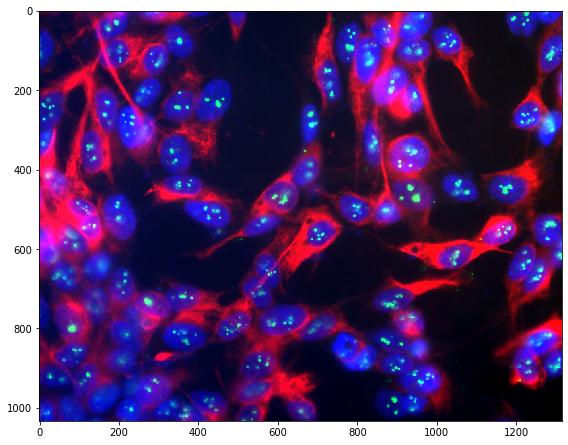

In [66]:
# Read the image
cells = imread("cells_segm.tif")

# Print its shape
print(cells.shape)

# Display the image
imshow(cells)

The image (source GerryShaw, [Wikimedia](https://commons.wikimedia.org/wiki/File:38F3-ChkNFH-DAPI-Shsy5y.jpg)) shows human SH-SY5Y cells.
Channel 0 contains staining of the cells cytoskeleton, channel 1 staining for a nucleolar protein, and channel 2 shows DNA (nuclear) staining.

We would like to determine which pixels correspond to nuclei. We would like to end up with a matrix of the same size as the original image, where each element is 1 if the pixel is in a nucleus, and 0 if it is elsewhere (cytoplasm or background)

Let's start by isolating the channel with the nuclear staining; you can use `imshow` to ensure you got the correct one!

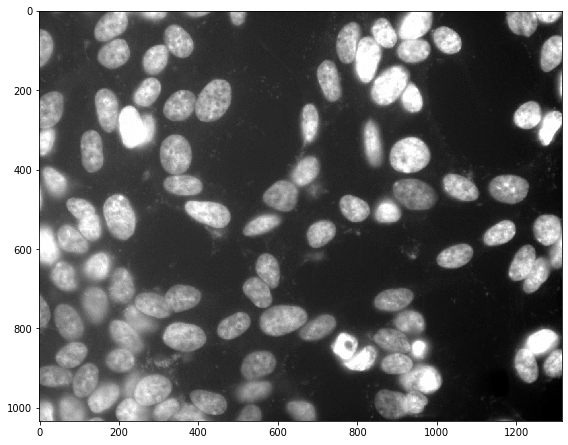

In [67]:
nuclei = cells[:, :, 2]

imshow(nuclei)

Let's start by plotting the image histogram to get an idea of the distribution of staining.
We would expect two peaks: one corresponding to background and one corresponding to nuclear staining

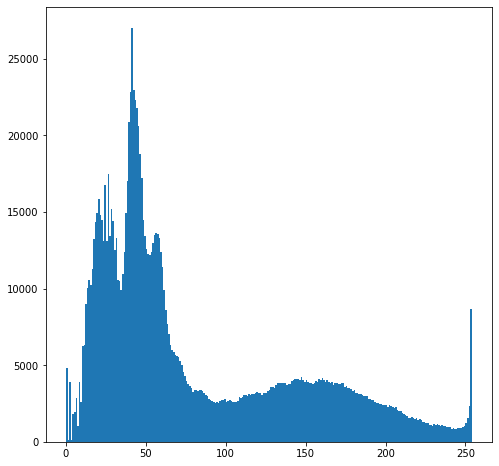

In [68]:
_ = plt.hist(nuclei.ravel(), bins=range(255))

The histogram tells us a lot! We can clearly distinguish background from nuclei, but rather than having a single background peak we get multiple ones.

**Can you explain why?**

We can now try to manually choose a threshold to separate nuclei from background.

**Use the histogram to try and find the value that best separates background from nuclei.**

You can try a few values and get a feeling for the one that visually gives the same result.

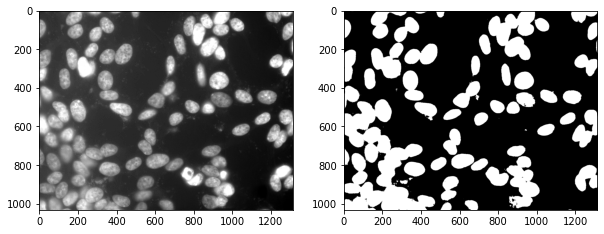

In [81]:
nuclei_threshold_manual = nuclei>95

fig, ax = plt.subplots(ncols=2, nrows=1, figsize = (10, 5))

ax[0].imshow(nuclei, cmap="gray")
ax[1].imshow(nuclei_threshold_manual, cmap="gray")


Let's say you now want to determine what percentage of the image is occupied by cell nuclei?

**How would you do that?**

_Hint:_ you can use the numpy function `unique` with the `return_counts` parameter set to `True`. What does this function return? How can it help in answering the question above?

In [53]:
values, counts = np.unique(nuclei_threshold_manual, return_counts=True)
print(f"Percentage of image covered by nuclei is {counts[1]/(counts[0]+counts[1])*100:.2f}%")

Percentage of image covered by nuclei is 33.28%


As we saw in the lecture, there are better, more automatable, ways to determine an optimal threshold.

Scikit Image provides several methods, which are imported below. 

- Apply the different methods to the image
- Note that you have to specify the `block_size` parameter for `threshold_local` (and it MUST be an odd number). What happens if the block size is too small?
- Visually compare the results of the various methods, including the manual thresholding
- Calculate the percentage of pixels containing nuclei in the image in the various cases
- Is there anything that stand out? How good was your manual threshold compared to the automatic methods?


Otsu - percentage of image covered by nuclei is 30.91%
Li - percentage of image covered by nuclei is 34.64%
Local - percentage of image covered by nuclei is 32.19%


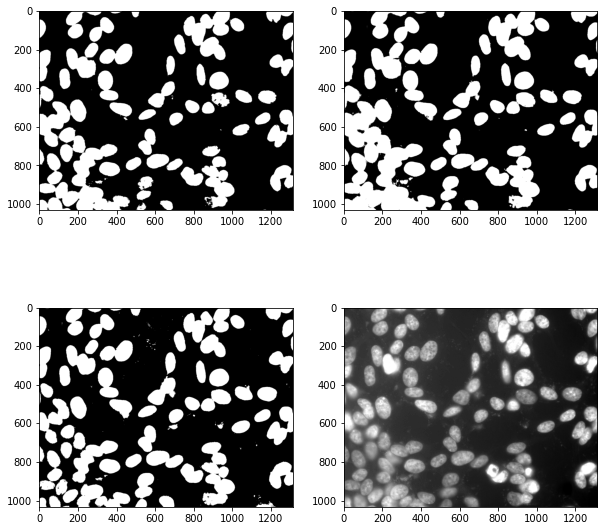

In [82]:
from skimage.filters import threshold_otsu, threshold_li, threshold_local

nuclei_threshold_otsu = nuclei > threshold_otsu(nuclei)
nuclei_threshold_li = nuclei > threshold_li(nuclei)
nuclei_threshold_local = nuclei > threshold_local(nuclei, block_size=399)

# Now show the images
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (10, 10))
ax[0, 0].imshow(nuclei_threshold_otsu, cmap="gray")
ax[0, 1].imshow(nuclei_threshold_li, cmap="gray")
ax[1, 0].imshow(nuclei_threshold_local, cmap="gray")
ax[1, 1].imshow(nuclei, cmap="gray")

values, counts = np.unique(nuclei_threshold_otsu, return_counts=True)
print(f"Otsu - percentage of image covered by nuclei is {counts[1]/(counts[0]+counts[1])*100:.2f}%")
values, counts = np.unique(nuclei_threshold_li, return_counts=True)
print(f"Li - percentage of image covered by nuclei is {counts[1]/(counts[0]+counts[1])*100:.2f}%")
values, counts = np.unique(nuclei_threshold_local, return_counts=True)
print(f"Local - percentage of image covered by nuclei is {counts[1]/(counts[0]+counts[1])*100:.2f}%")

## Instance segmentation

Instance segmentation is definitely a harder problem to solve.
For each pixel, not only we want to define whether it is in a nucleus, but also which nucleus it is in!

This will allow us to make cell-level measurements, a very useful tool for analysis of biological images! 